# Classification of Alzhaimer through Brain MRI

In [28]:
# Package imports.
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random

import tensorflow as tf
from keras.utils import to_categorical
from keras import layers
from sklearn import model_selection, metrics, preprocessing

In [29]:
# Import and mount Google Drive.
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [31]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [32]:
# Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 115
data = []
labels = []
paths=[]
for folder in os.listdir(folder_path):
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg"):
            labels.append(folder)
            # Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            # Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            # Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)

# Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [9]:
#labels_np=np.array(labels)
#selected_indices={}
#for t in ['Mild Dementia','Non Demented','Very mild Dementia']:
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],500,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],np.where(labels_np=='Moderate Dementia')[0]))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [10]:
data_arr.shape

(1988, 115, 115, 3)

In [11]:
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [12]:
print('Mild Dementia:',labels.count("Mild Dementia"))
print('Moderate Dementia:',labels.count("Moderate Dementia"))
print('Non Demented:',labels.count("Non Demented"))
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 500
Moderate Dementia: 488
Non Demented: 500
Very mild Dementia: 500


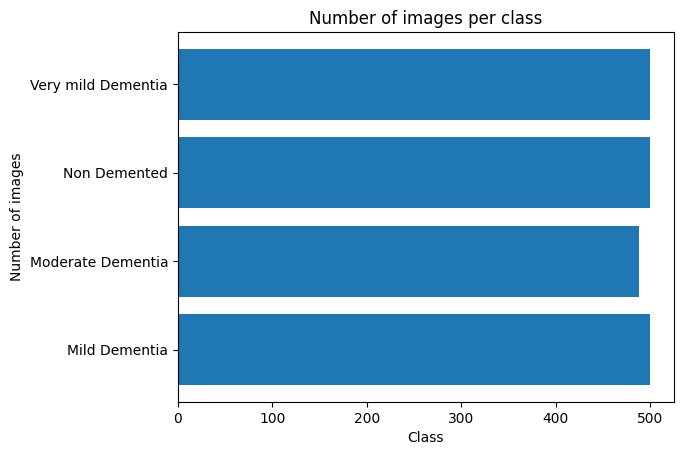

In [22]:
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

Text(0.5, 1.0, 'Very mild Dementia')

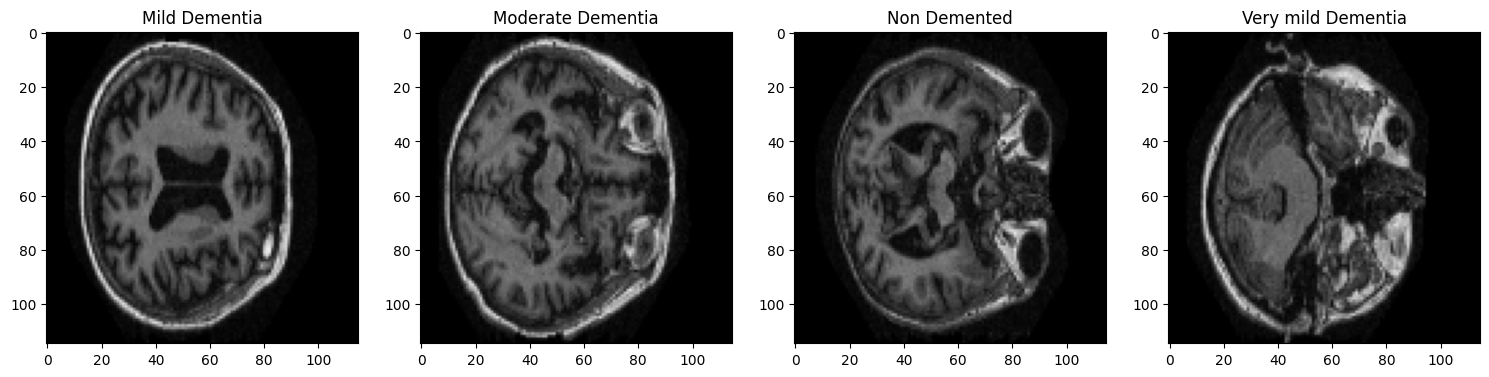

In [63]:
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,500),1)[0]])
ax[0].set_title('Mild Dementia')
ax[1].imshow(data_arr[np.random.choice(range(501,1000),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[2].imshow(data_arr[np.random.choice(range(1001,1500),1)[0]])
ax[2].set_title('Non Demented')
ax[3].imshow(data_arr[np.random.choice(range(1501,2000),1)[0]])
ax[3].set_title('Very mild Dementia')